In [1]:
# use a single feature linear model to classify words as {'BAD'; 'OK'}

import numpy as np
import codecs

from sklearn.metrics import f1_score


In [2]:
# Original Basedir: /media/1tb_drive/imt_models/EN-DE-confidence-baseline-PREDICTION_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/

# with open('newstest2014.500.bpe_imt_test_en-de.tercom.out.pra.tags') as inp:
#     ts = [l.split() for l in inp.read().strip().split('\n')]

with open('/home/chris/projects/neural_qe/data/wmt16/task2_en-de_dev/dev.tags.bpe') as inp:
    ts = [l.split() for l in inp.read().strip().split('\n')]

In [3]:
with codecs.open('/home/chris/projects/neural_qe/data/wmt16/task2_en-de_dev/dev.mt.bpe', encoding='utf8') as inp:
    ps = [l.split() for l in inp.read().strip().split('\n')]


In [5]:
# Evaluating different confidence models
cs = [l[0] for l in np.load(open('/home/chris/projects/neural_qe/data/wmt16/task2_en-de_dev/wmt2016_qe.dev.bpe.imt-confidences.prediction_trained_final.npz'))]
# orig_word_level_confs = [l[0] for l in numpy.load(open(confidences_file))]

# cs = [l[0] for l in np.load(open('newstest2014.de.500.bpe.imt-confidences.npz'))]
# cs = [l[0] for l in np.load(open('/media/1tb_drive/imt_models/EN-DE-confidence-3layer-baseline-PREDICTION_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/' + \
#                                  'newstest2014.de.500.bpe.imt-confidences.npz'))]
# cs = [l[0] for l in np.load(open('/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_PREDICTION_model_baseline_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/' + \
#                                  'newstest2014.de.500.bpe.imt-confidences.npz'))]

# WORKING: evaluate pure confidence output
# cs = [l[0] for l in np.load(open('/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_PREDICTION_65000_iters_model_baseline_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/' + \
#                                  'newstest2014.de.500.bpe.imt-confidences.npz'))]

# cs = [l[0] for l in np.load(open('/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_l2_reg_model_baseline_internal_data_dropout0.5_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/' + \
#                                  'newstest2014.de.500.bpe.imt-confidences.15000_iters.npz'))]

# cs = [l[0] for l in np.load(open('/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_l2_reg_model_baseline_internal_data_dropout0.5_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/' + \
#                                  'newstest2014.de.500.bpe.imt-confidences.75000_iters.npz'))]



In [6]:
for p,c,t in zip(ps,cs,ts):               
    try:
        assert len(p) == len(c) == len(t)
    except AssertionError:
        print('P: {}, C: {}, T: {}'.format(p,c,t))


In [7]:
good_tag_confs = [t[1] for tags, confs in zip(ts, cs) for t in zip(tags, confs) if t[0] == 'OK']
bad_tag_confs = [t[1] for tags, confs in zip(ts, cs) for t in zip(tags, confs) if t[0] == 'BAD']

In [8]:
# get p,r and f1
tag_map = {'OK': 1, 'BAD': 0}
mapped_ts = np.array([tag_map[t] for r in ts for t in r]).astype('float32')

In [9]:
def preds_at_threshold(threshold, confidence_outputs):
    preds = np.array([c >= threshold for r in confidence_outputs for c in r], dtype='float32')
    return preds

In [10]:
num_points = 50
test_thresholds = np.linspace(.1, 1., num=num_points, endpoint=False)

In [25]:
class_scores = [f1_score(mapped_ts, preds_at_threshold(thresh, cs), pos_label=None, average=None) 
                for thresh in test_thresholds]
f1_bad_scores = [s[0] for s in class_scores]

weighted_avgs = [f1_score(mapped_ts, preds_at_threshold(thresh, cs), pos_label=None, average='weighted') 
                 for thresh in test_thresholds]


In [12]:
test_thresholds[np.argmax(weighted_avgs)]

0.35199999999999998

In [13]:
weighted_avgs[np.argmax(weighted_avgs)]
# np.argmax(weighted_avgs)

0.72335930620337108

In [26]:
best_threshold = test_thresholds[np.argmax(f1_bad_scores)]
best_threshold

0.67600000000000005

In [27]:
# class_scores

In [28]:
best_preds = preds_at_threshold(best_threshold, cs) 

In [29]:
f1_score(mapped_ts, best_preds, pos_label=None, average=None)


array([ 0.38214286,  0.57686497])

In [16]:

# f1_score(mapped_ts, preds, pos_label=None, average=None)

# first single layer merged_states: array([ 0.54927389,  0.64333134])
# multilayer merged states: array([ 0.65879438,  0.62687981])
# multilayer final_states 30000_iters: array([ 0.58604325,  0.6401998 ])
# multilayer final_states 65000_iters: array([ 0.60445352,  0.63979335])
# multilayer final states 100000 iters: array([ 0.48906182,  0.66291811])
# Orig source 65000_iters: array([ 0.60361414,  0.67312335]) -- why is this different than the original 65000 iters?
# Orig source 35000 iters: array([ 0.57377788,  0.66835659])

# Dropout + l2 reg 15000 iters: array([ 0.53738647,  0.66309669])
# Dropout + l2 reg 75000 iters: array([ 0.38994979,  0.6569826 ])
# -- same model -- use 0.8 as cutoff: array([ 0.71294216,  0.65057416])

NameError: name 'preds' is not defined

In [46]:
f1_score(mapped_ts, preds, pos_label=None, average='weighted')
# multilayer merged states: 0.64373983095908915
# multilayer final_states 30000_iters: 0.61158965417786482
# multilayer final_states 65000_iters: 0.62112381170756614
# multilayer final_states 100000_iters: 0.57107226413699619

0.68352230154836602

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import pylab
pylab.rcParams['figure.figsize'] = (14.0, 12.0)

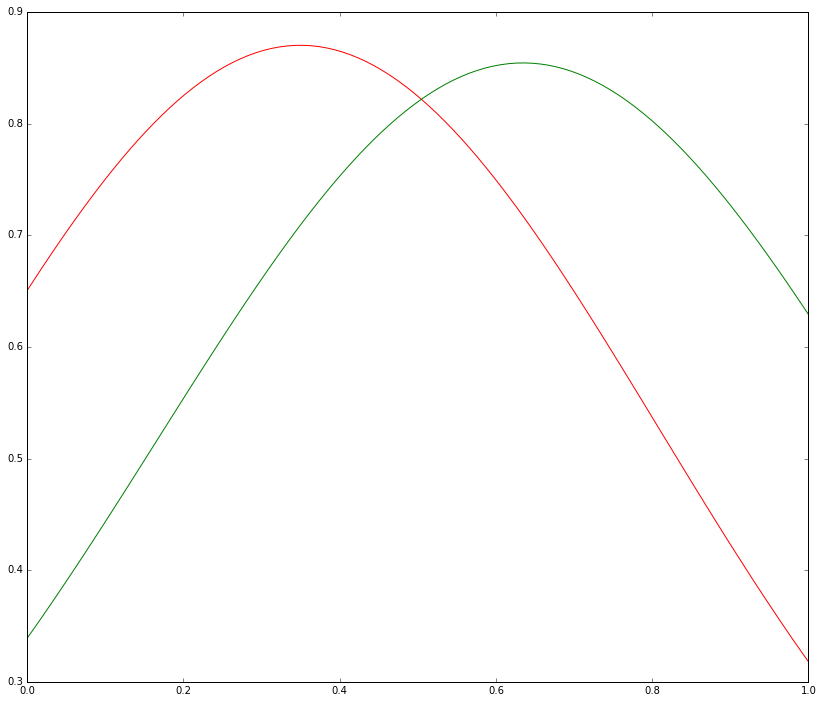

In [16]:
# plot gaussians 
good_mu = np.mean(good_tag_confs)
bad_mu = np.mean(bad_tag_confs)

bad_sigma = np.std(bad_tag_confs)
good_sigma = np.std(good_tag_confs)

x = np.linspace(0, 1, 100)

plt.plot(x,mlab.normpdf(x, bad_mu, bad_sigma), c='red')
plt.plot(x,mlab.normpdf(x, good_mu, good_sigma), c='green')

plt.show()

In [17]:
import os
import cPickle

In [18]:
# now check the performance against the simple accuracy priors
EXPERIMENT_DIR = '/media/1tb_drive/imt_models/word_prediction_accuracy_experiments/en-de/exp_1'
word_acc_priors_file = os.path.join(EXPERIMENT_DIR, 'word_accuracy_priors.pkl')

In [19]:
word_prior_map = cPickle.load(open(word_acc_priors_file))

In [20]:
avg_prior = np.mean(word_prior_map.values())
avg_prior

0.566366947432146

In [34]:
prior_preds = []
num_unks = 0

for l in ps:
    for w in l:
        if w in word_prior_map:
            if word_prior_map[w] >= 0.5:
                prior_preds.append(1)
            else:
                prior_preds.append(0)
        else:
            prior_preds.append(0)
            num_unks += 1

In [35]:
f1_score(mapped_ts, prior_preds, pos_label=None, average=None)

array([ 0.6495357 ,  0.60395435])

In [36]:
f1_score(mapped_ts, prior_preds, pos_label=None, average='weighted')

0.62803433856165203

In [24]:
num_unks / float(len(prior_preds))

0.17680200321945985

In [25]:
from collections import Counter

In [26]:
tag_counts = Counter(mapped_ts)
tag_counts

Counter({0.0: 100424, 1.0: 89670})

In [27]:
bad_prior = tag_counts[0.0] / float(sum(tag_counts.values()))
bad_prior

0.5282860058707797

In [28]:
good_prior = tag_counts[1.0] / float(sum(tag_counts.values()))
good_prior

0.47171399412922027

In [29]:
random_tags = [np.random.choice([0,1], p=[0.529, 0.471]) for _ in range(sum(tag_counts.values()))]

In [30]:
f1_score(mapped_ts, random_tags, average=None)

array([ 0.52804208,  0.46968597])